In [59]:
#Import Turing, Distributions, StatsBase, DataFrames and CSV
using Turing, Distributions, StatsBase, DataFrames, CSV

# Import MCMCChain, Plots and StatsPlots
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/RZOZ8/src/Turing.jl:24


false

In [81]:
# Load in the shampoo dataset (can be downloaded from https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv)
df = CSV.read("../data/DowJones.csv")
plot(df[:date], df[:value])

ArgumentError: ArgumentError: column name :date not found in the data frame

In [77]:
s = Float64[]
for ele in df[:value]
    push!(s, ele)
end
pyplot()

Plots.PyPlotBackend()

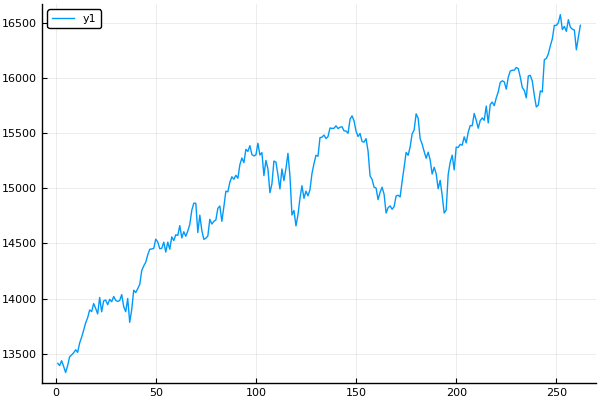

In [78]:
# Split into training and test sets. We will predict for the next 4 days using the data from the past 32 days
train_percentage = 0.90
s_train = s[1:floor(Int, train_percentage*length(s))]
N = length(s_train)

# Plot the training data
plot(s_train)

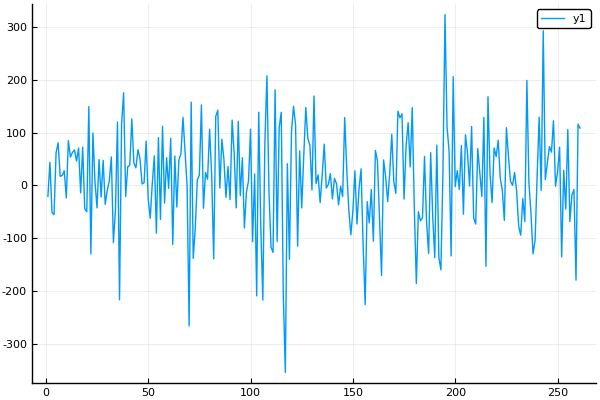

In [79]:
s_diff = diff(s_train)
plot(s_diff)

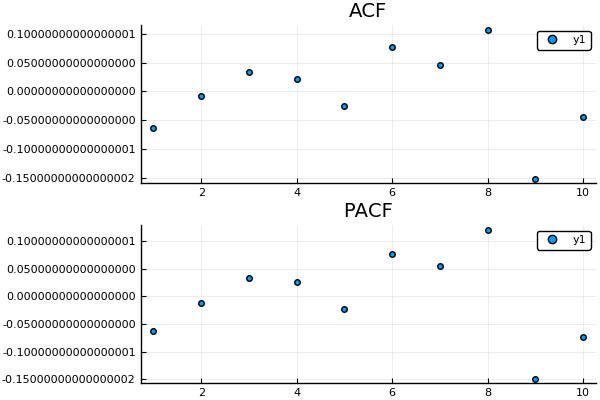

In [80]:
#Plot ACF and PACF plots
total_lags = 10
s1 = scatter(collect(1:total_lags), autocor(s_diff, collect(1:total_lags)), title = "ACF")
s2 = scatter(collect(1:total_lags), pacf(s_diff, collect(1:total_lags)), title = "PACF")
plot(s1, s2, layout = (2, 1))
# The PACF plot cuts off at k = 2, so we will have an AR(2) model for this dataset.

In [49]:
#Defining the model
σ = 1
@model ARIMA(x, N) = begin
    α ~ Normal(0,σ) 
    beta_1 ~ Uniform(-1, 1)
    for t in 3:N
        μ = α + beta_1*rand(Normal(0,1))
        x[t] ~ Normal(μ, 0.1) 
    end
end;